In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [4]:
# Configuration
data_dir = '../../dataset/train-curat-dataset'

In [5]:
model_name = 'alexnet' 
num_classes = 7
batch_size = 16
num_epochs = 200
feature_extract = True
 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
 #initilize the alexnet model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "alexnet":
        """ alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[-1].in_features
        model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [12]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
 
# Print the model architecture
#print(model_ft)

# Send the model to GPU
model_ft = model_ft.to(device)

In [13]:
'''
Gather the parameters to be optimized/updated in this run. If we are
fine-tuning we will be updating all parameters. However, if we are
doing feature extract method, we will only update the parameters
that we have just initialized, i.e. the parameters with requires_grad
is True
'''
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
 
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
 
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [14]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [15]:
###
# Train and evaluate
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
 

Epoch 0/199
----------
train Loss: 0.8876 Acc: 0.6845
val Loss: 0.6092 Acc: 0.7881
Epoch 1/199
----------
train Loss: 0.5726 Acc: 0.7975
val Loss: 0.4836 Acc: 0.8398
Epoch 2/199
----------
train Loss: 0.5157 Acc: 0.8197
val Loss: 0.4430 Acc: 0.8449
Epoch 3/199
----------
train Loss: 0.4624 Acc: 0.8378
val Loss: 0.4708 Acc: 0.8398
Epoch 4/199
----------
train Loss: 0.4671 Acc: 0.8261
val Loss: 0.4582 Acc: 0.8411
Epoch 5/199
----------
train Loss: 0.4284 Acc: 0.8441
val Loss: 0.4138 Acc: 0.8625
Epoch 6/199
----------
train Loss: 0.4149 Acc: 0.8466
val Loss: 0.3958 Acc: 0.8714
Epoch 7/199
----------
train Loss: 0.4046 Acc: 0.8639
val Loss: 0.4562 Acc: 0.8436
Epoch 8/199
----------
train Loss: 0.4004 Acc: 0.8592
val Loss: 0.3936 Acc: 0.8651
Epoch 9/199
----------
train Loss: 0.3798 Acc: 0.8609
val Loss: 0.3872 Acc: 0.8663
Epoch 10/199
----------
train Loss: 0.3743 Acc: 0.8634
val Loss: 0.3774 Acc: 0.8764
Epoch 11/199
----------
train Loss: 0.3584 Acc: 0.8668
val Loss: 0.3880 Acc: 0.8663
Ep

In [20]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'building_orig_alexnet_weights.pth')

In [21]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

/tmp/ipykernel_2500318/1057995073.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_acc_hist = torch.tensor(train_acc_hist)
/tmp/ipykernel_2500318/1057995073.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_acc_hist = torch.tensor(val_acc_hist)
/tmp/ipykernel_2500318/1057995073.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss_hist = torch.tensor(train_loss_hist)
/tmp/ipykernel_2500318/1057995073.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

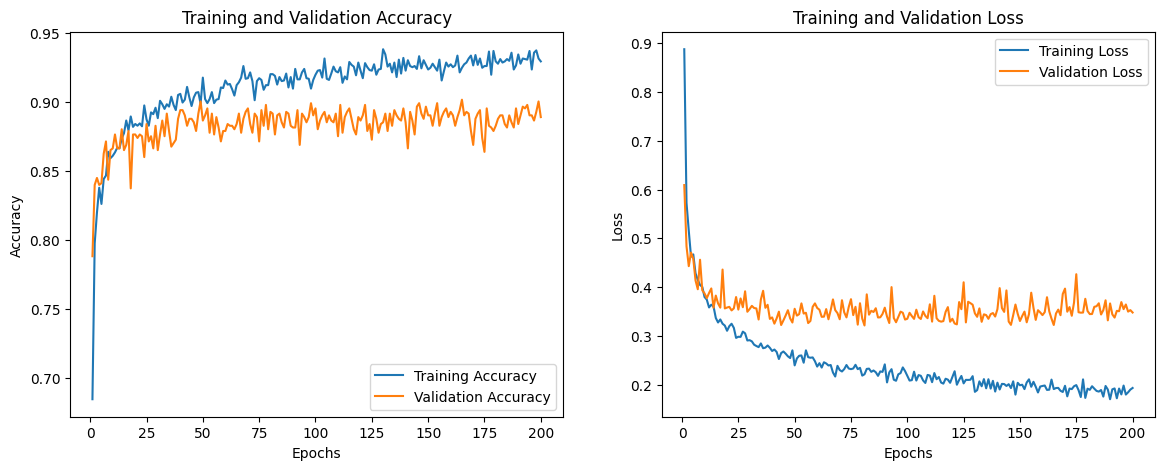

In [22]:
# Plot training and validation accuracy and loss
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)


In [24]:
# Evaluate the model on test data
model_ft.eval()
test_corrects = 0
all_preds = []
all_labels = []
 
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Test Accuracy: 0.8801
Confusion Matrix:
 [[114   1   2   1   0   3   3]
 [  1  99  15   0   1   0   0]
 [  0   7 117   0   0   0   0]
 [  0   3   4  86   0   1  10]
 [  0   1   1   0 117   0   1]
 [  2   4   1   4   0  80   9]
 [  2   1   7   4   3   3  84]]
Classification Report:
               precision    recall  f1-score   support

       algae       0.96      0.92      0.94       124
 major_crack       0.85      0.85      0.85       116
 minor_crack       0.80      0.94      0.86       124
     peeling       0.91      0.83      0.86       104
       plain       0.97      0.97      0.97       120
    spalling       0.92      0.80      0.86       100
       stain       0.79      0.81      0.80       104

    accuracy                           0.88       792
   macro avg       0.88      0.88      0.88       792
weighted avg       0.88      0.88      0.88       792



In [25]:


# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('curat_alexnet_results.csv', index=False)

          actual    predicted
0    major_crack  major_crack
1        peeling      peeling
2        peeling      peeling
3    minor_crack  minor_crack
4          algae        algae
..           ...          ...
787        algae  minor_crack
788  minor_crack  minor_crack
789     spalling     spalling
790        algae        algae
791        plain        plain

[792 rows x 2 columns]


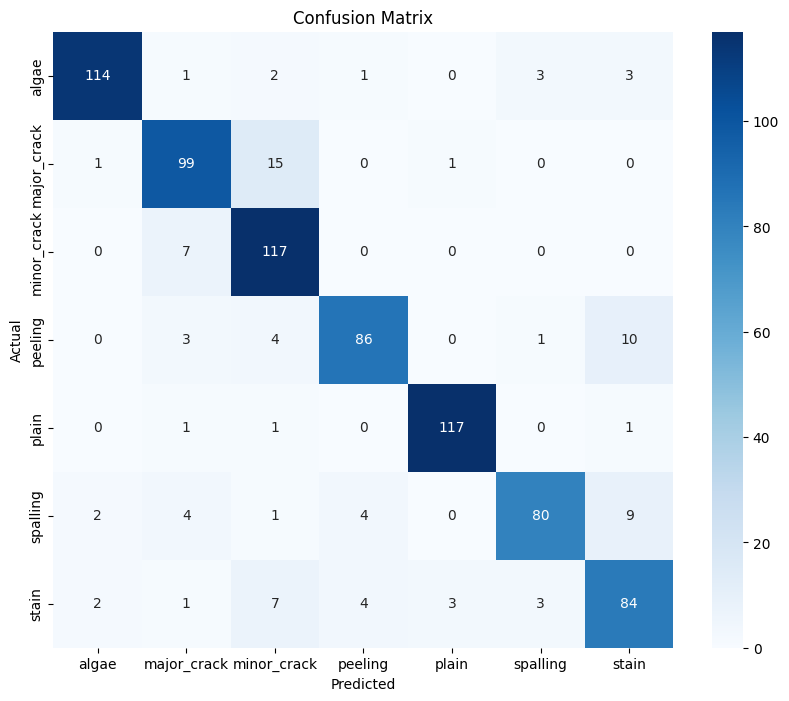

In [26]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('building_orig_alexnet_confusion_matrix.png')
plt.show()
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3502399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5245317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2445416..1.0365143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.9254032].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.317927..1.2805231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.8622224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.

Accuracy: 0.8801
Average Precision: 0.8834
Average Recall: 0.8751
Average F1-Score: 0.8775


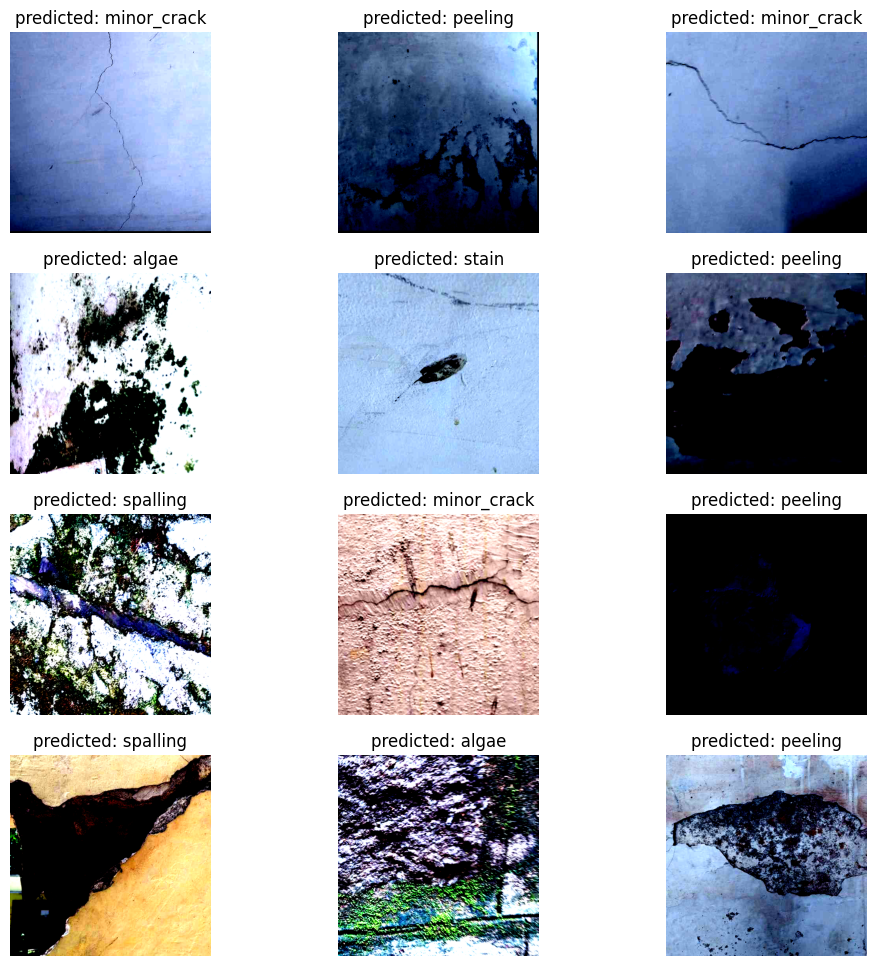

In [27]:
def visualize_model(model, dataloaders, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Increase the figure size
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(4, 3, images_so_far)  # Create a 3x3 grid of subplots
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    
    model.train(mode=was_training)


# Visualize some predictions
visualize_model(model_ft, dataloaders)
 
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")
 
# Ensure the confusion matrix and the classification report are saved
with open('curat_alexnet_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")